# A/B Testing Fast Food Marketing Campaigns 

The goal of this analysis is to discover which of three different marketing promotion campaigns are the most successful in prompting sales. Consequently, this code executes code to assess this through significance testing

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("WA_Marketing-Campaign.csv")
data

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


In [3]:
print(f"there are {data.index.size} rows in the dataset")
print("Duplicate rows:", data.duplicated().sum())
print("NaN values per column:\n", data.isna().sum())

there are 548 rows in the dataset
Duplicate rows: 0
NaN values per column:
 MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64


I also choose to merge the sales data across the four weeks. This is so that we have a list of stores and their total sales, rather than a list of weekly store sales amount. I do this for two reasons; 1) it ensures the independence of different datapoints - as otherwise different rows in fact represent data from the same row. Doing this will ensure that later assumptions for significance testing are more upheld. Secondly, I also do this so that it reduces the number of significance tests I later have to run, as otherwise I will increase my chances of getting a Type I error and p-hack more, since I, due to the dependence of datasets, would need to analyze results on a weekly basis.

Consequently, I also study all the data from this combined dataset.

In [4]:
aggregated_sales = data.groupby(['MarketID', 'MarketSize', 'LocationID', 'AgeOfStore', 'Promotion'])['SalesInThousands'].sum().reset_index()
aggregated_sales

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,SalesInThousands
0,1,Medium,1,4,3,137.68
1,1,Medium,2,5,2,118.18
2,1,Medium,3,12,1,162.72
3,1,Medium,4,1,2,134.83
4,1,Medium,5,10,2,116.01
...,...,...,...,...,...,...
132,10,Large,916,7,2,191.04
133,10,Large,917,14,3,211.87
134,10,Large,918,6,1,223.90
135,10,Large,919,2,1,244.40


### Overview of Relevant Data

The following two graphs give an overview of total sales by promotion type. I first give showcase this through a bar graph with analytical confidence intervals, and thereafter as one with bootstrapped confidence intervals. As there is arguably some issue with our normality, as is later covered (though the Central Limit Theorem is applied here), one could make a slight argument for the latter being more valid. 

This shows that promotion 1 has the highest overall sales (M = 232.4), followed closely by promotion 3 (M = 221.46), with promotion 2 being quite far behind (M = 189.32). I here focus on month-wide data, as that is what I will be significance-testing later. However, more detailed analyses by week and market size can be seen through the custom Looker report I built for this purpose: https://lookerstudio.google.com/u/0/reporting/0b087836-5d77-4f70-9c38-99f09426cf8c/page/3f9EF

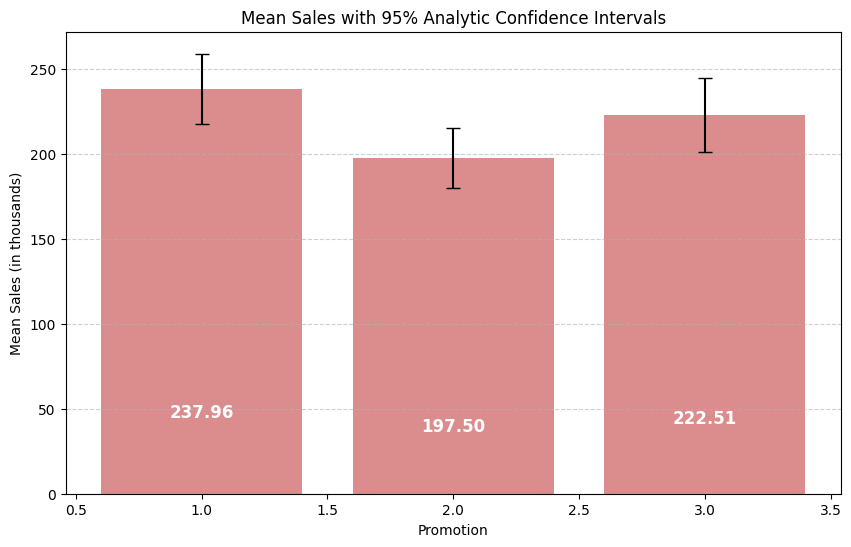

In [21]:
def compute_ci_analytically(data, group_column, value_column, confidence_level=0.95):
    ci_lower = []
    ci_upper = []
    mean_sales = []
    groups = data[group_column].unique()
    
    for group in groups:
        group_data = data[data[group_column] == group][value_column]
        mean = group_data.mean()
        sem = stats.sem(group_data)  # Standard Error of the Mean
        n = len(group_data)
        confidence_interval = stats.t.interval(confidence_level, n-1, loc=mean, scale=sem)
        
        mean_sales.append(mean)
        ci_lower.append(confidence_interval[0])
        ci_upper.append(confidence_interval[1])
    
    return groups, np.array(mean_sales), np.array(ci_lower), np.array(ci_upper)

groups, mean_sales, ci_lower, ci_upper = compute_ci_analytically(aggregated_sales, 'Promotion', 'SalesInThousands')

plt.figure(figsize=(10, 6))
bars = plt.bar(groups, mean_sales, yerr=[mean_sales - ci_lower, ci_upper - mean_sales], 
               capsize=5, color='indianred', alpha=0.7)

for bar, value in zip(bars, mean_sales):
    plt.text(bar.get_x() + bar.get_width() / 2,  
             bar.get_height() * 0.2,  
             f'{value:.2f}', 
             ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.xlabel('Promotion')
plt.ylabel('Mean Sales (in thousands)')
plt.title('Mean Sales with 95% Analytic Confidence Intervals')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


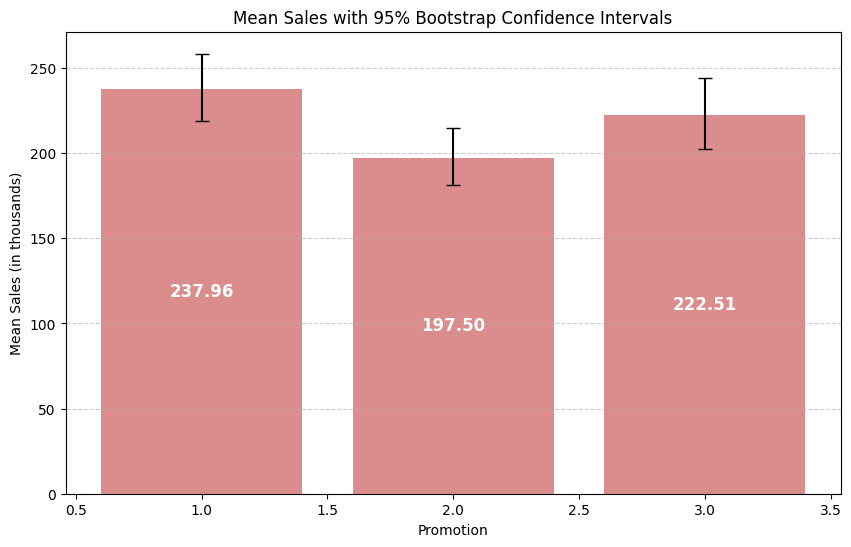

In [22]:
def compute_ci_bootstrap(data, group_column, value_column, confidence_level=0.95, n_iterations=10000):
    ci_lower = []
    ci_upper = []
    mean_sales = []
    groups = data[group_column].unique()
    
    for group in groups:
        group_data = data[data[group_column] == group][value_column].values
        bootstrap_means = []
        
        for _ in range(n_iterations):
            sample = np.random.choice(group_data, size=len(group_data), replace=True)
            bootstrap_means.append(np.mean(sample))
        
        lower = np.percentile(bootstrap_means, (1 - confidence_level) / 2 * 100)
        upper = np.percentile(bootstrap_means, (1 + confidence_level) / 2 * 100)
        
        mean_sales.append(np.mean(group_data))
        ci_lower.append(lower)
        ci_upper.append(upper)
    
    return groups, np.array(mean_sales), np.array(ci_lower), np.array(ci_upper)

groups, mean_sales, ci_lower, ci_upper = compute_ci_bootstrap(aggregated_sales, 'Promotion', 'SalesInThousands')

plt.figure(figsize=(10, 6))
bars = plt.bar(groups, mean_sales, yerr=[mean_sales - ci_lower, ci_upper - mean_sales], 
               capsize=5, color='indianred', alpha=0.7)

for bar, value in zip(bars, mean_sales):
    plt.text(bar.get_x() + bar.get_width() / 2,  
             bar.get_height() / 2,  
             f'{value:.2f}', 
             ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.xlabel('Promotion')
plt.ylabel('Mean Sales (in thousands)')
plt.title('Mean Sales with 95% Bootstrap Confidence Intervals')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


Furthermore, it is interesting to note the varying data there is around ages of stores and the market size they belong to. This clearly shows that medium markets are the most common (80 data points), followed by large (42), and finally small markets (15). Furthermore, the average age of a store is 8.5, though the relatively large standard deviation of 6.66 shows that there is a large variety in age - indeed almost as large as the mean age itself.

In [7]:
market_size_counts = aggregated_sales['MarketSize'].value_counts().reset_index()
market_size_counts.columns = ['MarketSize', 'Count']
print(market_size_counts)

  MarketSize  Count
0     Medium     80
1      Large     42
2      Small     15


In [8]:
store_age = aggregated_sales['AgeOfStore'].mean()
store_age_std = aggregated_sales['AgeOfStore'].std()
print(f"The average age of a store is {store_age:.2f}, with a standard deviation of {store_age_std:.2f}")

The average age of a store is 8.50, with a standard deviation of 6.66


## Running an ANOVA to spot differences between the three promotion types

Next, I want to study whether there are actually any significant different between the three. I choose to run an ANOVA as it is an ideal test for conducting significance-testing between more than two groups. First, I check the assumptions of this model, which are as follows:
- No Significant Outliers: there must not be any significant outliers in the data.
- Normality: data must be normal
- Homogeneity of Variances: the different groups must have an equally distributed variance
- Independence: Different groups must be independent from one another
- Measurement Level: the different groups must have continuous or interval-ratio data - which is what this data already has. As such, this is not studied further

### Checking for Outliers

Promotion 1 - Outliers: 7
Promotion 2 - Outliers: 6
Promotion 3 - Outliers: 8


C:\Users\david\AppData\Local\Temp\ipykernel_5696\68349160.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



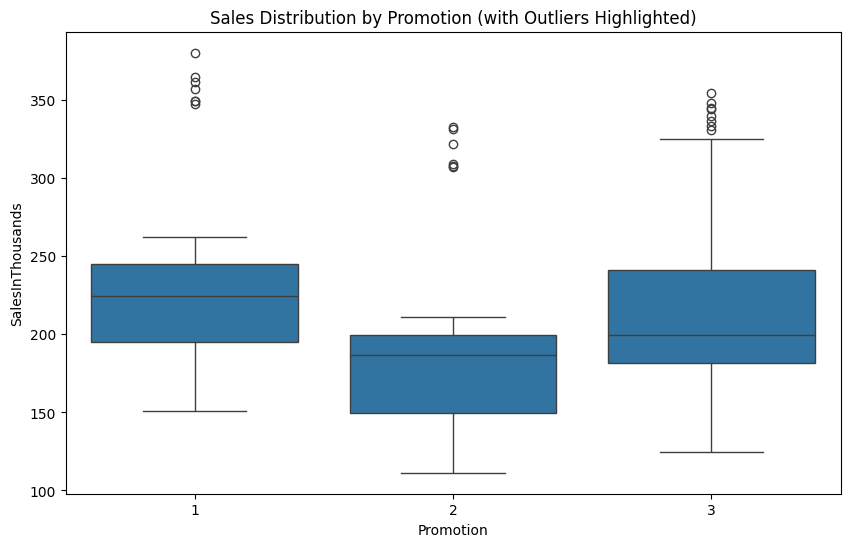

In [9]:
def detect_outliers(group):
    Q1 = group['SalesInThousands'].quantile(0.25)
    Q3 = group['SalesInThousands'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = group[(group['SalesInThousands'] < lower_bound) | 
                     (group['SalesInThousands'] > upper_bound)]
    
    print(f"Promotion {group['Promotion'].iloc[0]} - Outliers: {len(outliers)}")
    return outliers

outliers = aggregated_sales.groupby('Promotion').apply(detect_outliers).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Promotion', y='SalesInThousands', data=aggregated_sales)
plt.title('Sales Distribution by Promotion (with Outliers Highlighted)')
plt.show()

aggregated_sales = aggregated_sales.loc[~aggregated_sales.index.isin(outliers.index)].copy()

### Checking for Normality

First, I check to see whether the assumption of normality is upheld. As can be seen, the three data groups all fail the Shapiro-Wilkes test for normality, and the Q-Q plots and histograms showcases a slight multimodality in the dataset. One could on the other hand apply the central limit theorem here to stave off concerns here, since the sample size of each group is larger than 30 (at least 43 in each).

In [10]:
for promo in [1, 2, 3]:
    stat, p_value = stats.shapiro(aggregated_sales[aggregated_sales['Promotion'] == promo]['SalesInThousands'])
    print(f"Promotion {promo}: p-value = {p_value:.4f}")

    if p_value < 0.05:
        print(f"→ Promotion {promo} data is NOT normally distributed.")
    else:
        print(f"→ Promotion {promo} data appears normally distributed.")

Promotion 1: p-value = 0.0002
→ Promotion 1 data is NOT normally distributed.
Promotion 2: p-value = 0.0000
→ Promotion 2 data is NOT normally distributed.
Promotion 3: p-value = 0.0000
→ Promotion 3 data is NOT normally distributed.


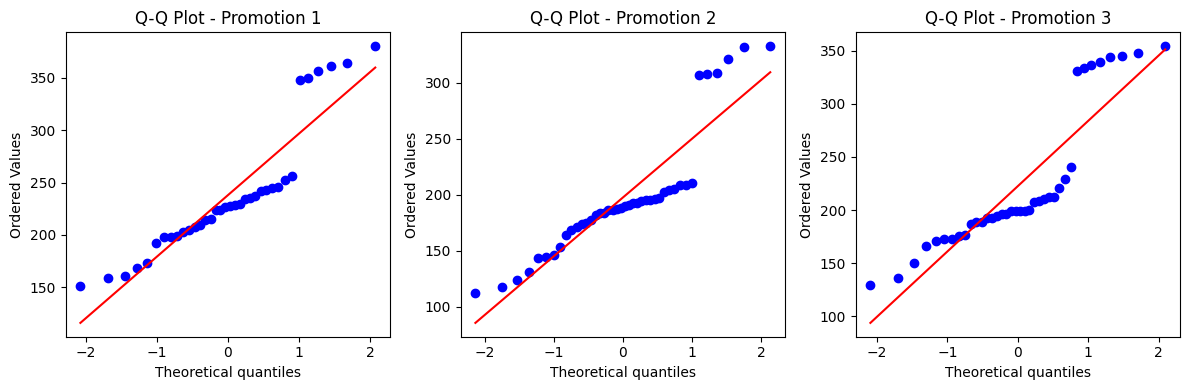

In [11]:
plt.figure(figsize=(12, 4))
for i, promo in enumerate([1, 2, 3], 1):
    plt.subplot(1, 3, i)
    stats.probplot(aggregated_sales[aggregated_sales['Promotion'] == promo]['SalesInThousands'], dist='norm', plot=plt)
    plt.title(f'Q-Q Plot - Promotion {promo}')

plt.tight_layout()
plt.show()

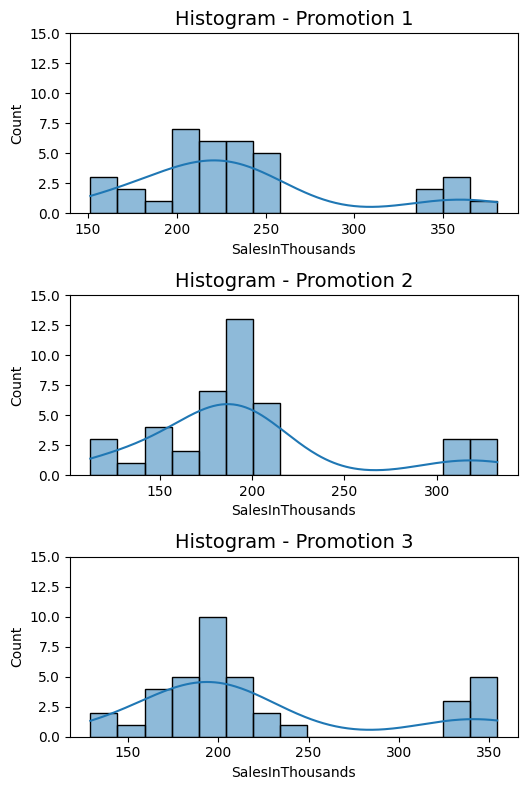

In [12]:
plt.figure(figsize=(10, 8))
for i, promo in enumerate([1, 2, 3], 1):
    plt.subplot(3, 2, 2*i)
    sns.histplot(aggregated_sales[aggregated_sales['Promotion'] == promo]['SalesInThousands'], kde=True, bins=15)
    plt.title(f'Histogram - Promotion {promo}', fontsize=14)
    plt.ylim(0, 15)

plt.tight_layout()
plt.show()

In [13]:
for i in [1, 2, 3]:
    s_size = aggregated_sales[aggregated_sales['Promotion'] == i].shape[0]
    print(f"Promotion {i} has a sample size of {s_size}")

Promotion 1 has a sample size of 36
Promotion 2 has a sample size of 42
Promotion 3 has a sample size of 38


### Checking Homogeneity of Variances

As shown below, the different groups do indeed seem to have similar variances, thus upholding this assumption of the model.

In [14]:
stat, p_value = stats.levene(
    aggregated_sales[aggregated_sales['Promotion'] == 1]['SalesInThousands'],
    aggregated_sales[aggregated_sales['Promotion'] == 2]['SalesInThousands'],
    aggregated_sales[aggregated_sales['Promotion'] == 3]['SalesInThousands']
)
print(f"Levene’s Test p-value = {p_value:.4f}")
if p_value < 0.05:
    print("→ Variances are NOT equal (assumption violated).")
else:
    print("→ Variances are equal (assumption upheld).")

Levene’s Test p-value = 0.6931
→ Variances are equal (assumption upheld).


### Checking Independence of Groups

This step sadly cannot be investigated in depth, as we do not know anything about how the sample was drawn, or how different the stimuli was in the promotions. This harms our model, as we cannot speak with confidence about this key assumption.

However, by merging each store across their four weeks of data collection, we do increase independence (as store level data is naturally dependent on other store-level data), so that we have a list of stores and their monthly sales, instead of a list of repeating stores with weekly sales.

### Running the ANOVA

The hypotheses being tested here are as follows:

- H0: There *is no* significant difference in total sales between stores using the different promotion campaigns
- H1: There *is a* significant difference in total sales between stores using the different promotion campaigns
- 
As can be seen below, the ANOVA indicates that there indeed is a significant difference between the three different groups, with a p-value less than 0.01.

In [15]:
sales_promo1 = aggregated_sales[aggregated_sales['Promotion'] == 1]['SalesInThousands']
sales_promo2 = aggregated_sales[aggregated_sales['Promotion'] == 2]['SalesInThousands']
sales_promo3 = aggregated_sales[aggregated_sales['Promotion'] == 3]['SalesInThousands']

f_stat, p_value = stats.f_oneway(sales_promo1, sales_promo2, sales_promo3)

print(f"F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value:.12f}")

F-statistic: 4.39
P-value: 0.014624689786


### Running Tukey's Pairwise Comparisons to spot differences between the groups

However, when conducting further pairwise comparisons to spot which groups are significant from each other, it is found that there is not a significant difference between promotion 1 and 3, nor between 2 and 3. However, there is a significant difference between promotion 1 and 2 (p < 0.05). Below you can also see how there seems to be slight differences between the groups. Thus, based on this ANOVA, as well as by looking at the size of the effect differences, there does not seem to be very much of substance. Regardless, promotion 1 is of course indicated to be the most effective.

It could be that that the small sample sizes, exacerbated by the cutting out outliers, also hampens the discovery of effects. As such, larger sample sizes would be beneficial.

In [16]:
tukey_result = pairwise_tukeyhsd(aggregated_sales['SalesInThousands'], aggregated_sales['Promotion'])
print(tukey_result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -40.4635 0.0118 -73.4278 -7.4991   True
     1      3 -15.4464 0.5242 -49.2019 18.3092  False
     2      3  25.0171  0.165  -7.4768  57.511  False
-----------------------------------------------------


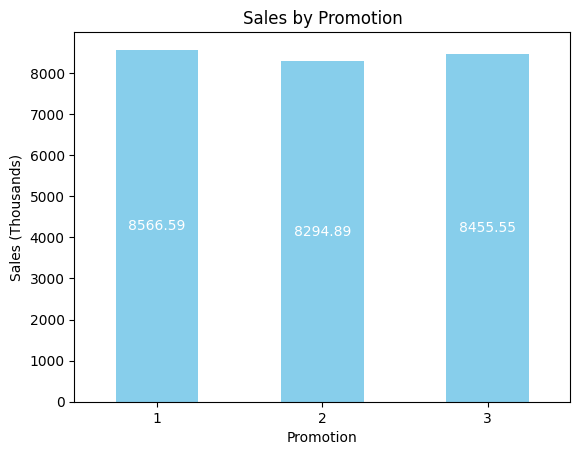

In [17]:
sales_by_promotion = aggregated_sales.groupby('Promotion')['SalesInThousands'].sum()

ax = sales_by_promotion.plot(kind='bar', color='skyblue')

plt.title('Sales by Promotion')
plt.xlabel('Promotion')
plt.ylabel('Sales (Thousands)')
plt.xticks(rotation=0)

for i, v in enumerate(sales_by_promotion):
    ax.text(i, v / 2, str(round(v, 2)), ha='center', va='center', color='white')

plt.show()

# Conclusion

In summary, the A/B test shows that promotions 1 and 3 have the highest monthly sales, with Promotion 1 exhibiting a mean monthly sales amount of 232.4, Promotion 2 showing 189.32, and Promotion 3 showing 221.46. While this clearly shows Promotion 1 to have the highest sales, one should note that while an ANOVA showed the groups to have significant differences between them, a Tukey pairwise comparison did not find a significant difference between Promotion 1 and 3 or between 2 and 3. Consequently, we can only conclude that Promotion 1 was the most successful (without a hierarchy between them), with Promotion 2 being the least successful at prompting sales. To speak more confidently about differences between the two most successful strategies, we would benefit from having a large sample size. 

However, when inspecting the data more closely on a week by week basis, we do in fact see that Promotion 3 consistently prompts the largest degree of sales. This can be witnessed through the following Looker report: https://lookerstudio.google.com/reporting/0b087836-5d77-4f70-9c38-99f09426cf8c. While this is not a significance test, and thus does not provide a statistical degree of support for the promotion being more successful, it could still serve some, albeit less confident, degree of indication. This is also as, at least partially, the high p-value for discerning Promotion 3 from 1 is influenced by the very small degree of difference. This reasserts the need for a larger sample to really know for sure.

In discussing the assumptions underpinning this model and its results, we should note that while normality and a homogeneity of variances is argued to be upheld, we cannot say much about whether the different groups are independent. This is due to us not being made aware of the circumstances of data collection, or the promotions themselves. It could, for example, be that promotions 1 and 3 share a lot of design features, and consequently share outcomes.

Regardless, on the basis of this data, a case is made for promotions 1 and 3 having the highest success rate. As a consequence, the business should continue exploring this vein as opposed to promotion 2, or downright choose one of these approaches as its approach.

One could also dive further into this by discussing a week-by-week difference. However, doing so would also subject the data to a large amount of testing, which would increase the risks of p-hacking due to increasing the chance of getting a Type I error.